In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
import sys
sys.path.append('/content/drive/My Drive/CS7643_GroupProject')

In [84]:
import pandas as pd
import numpy as np
import csv
import random
from PIL import Image
from collections import defaultdict
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt

from model.deep_emotion import Deep_Emotion

%matplotlib inline

#Preprocessing of the fer2013 dataset

Code modified from https://www.kaggle.com/code/vaibhavgovindwar/fer-cnn-lenet-5, https://www.kaggle.com/code/vkoriukina/fer2018-emotion-recognition-pytorch-resnet-18

In [85]:
df = pd.read_csv('/content/drive/My Drive/CS7643_GroupProject/data/fer2013.csv')

In [68]:
df.shape

(35887, 3)

In [69]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [70]:
df.Usage.value_counts()

,count
Usage,
Training,28709
PublicTest,3589
PrivateTest,3589


In [86]:
emotion_labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=True).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_labels)
emotion_counts

,emotion,number
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Disgust,547


# Seperate Train, Validation, Test Data

In [87]:
train_df = df[df['Usage']=='Training']
val_df   = df[df['Usage']=='PublicTest']
test_df  = df[df['Usage']=='PrivateTest']
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(train_df.shape, val_df.shape, test_df.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


# Create a custom dataset class
Convert pixel strings from csv file to image and label in tensor form

In [88]:
class FER2013Dataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (DataFrame): The dataset loaded using pandas DataFrame.
            transform (callable, optional): Optional transformations to apply to the images.
        """
        self.data = data
        self.transform = transform
        self.labels = data['emotion'].values
        self.pixels = data['pixels'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the pixel string to a numpy array, normalize the pixel by dividing by 255 and reshape to 48x48
        image = (np.array(self.pixels[idx].split(), dtype=np.float32)/255).reshape(48, 48)
        label = int(self.labels[idx])

        # Apply transformations if provided
        if self.transform:
            image = Image.fromarray((image * 255).astype(np.uint8))
            image = self.transform(image)

        # Convert image and label to tensors
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

#Define Transformation and Initialize Datasets

In [89]:
# Train transformation without data augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Normalize pixels to mean=0.5 and std=0.5
])

# Data augmentation of horizontal mirroring, ±10 degree rotations, ±10% image zooms, and ±10% horizontal/vertical shifting,
# Pixel values normalized to [-1, 1]
train_transform_with_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1), # ±10% horizontal and vertical shifting
        scale=(0.9, 1.1) # ±10% zoom (scale between 90% and 110%)
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Normalize pixels to mean=0.5 and std=0.5
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dataset = FER2013Dataset(train_df, train_transform)
train_dataset_with_augmentation = FER2013Dataset(train_df, train_transform_with_augmentation)
val_dataset = FER2013Dataset(val_df, test_transform)
test_dataset = FER2013Dataset(test_df, test_transform)

# Create DataLoader

In [90]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
train_augmented_dataloader = DataLoader(train_dataset_with_augmentation, BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE)

In [91]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Model = Deep_Emotion
Model description: Attentional Convolutional Neural Network

Model architecture: https://arxiv.org/abs/1902.01019

In [92]:
model = Deep_Emotion()
model = model.to(device)
print(model)

Deep_Emotion(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplac

# Define Optimizer, Loss Function and Hyperparameters

In [93]:
EPOCHS = 100
LEARNING_RATE = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), weight_decay=5e-2, lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Define Train, Validation and Accuracy Function

In [94]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    train_running_loss = 0.0
    train_running_acc = 0.0

    for images, labels in tqdm(dataloader, desc="Training...", total=len(dataloader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        train_running_loss += loss.clone().detach()
        train_running_acc += accuracy(outputs.clone().detach(), labels)

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / len(dataloader)
    train_acc = train_running_acc / len(dataloader)

    return train_loss, train_acc

In [95]:
def validate(model, dataloader, optimizer, loss_fn):
    model.eval()

    valid_running_loss = 0.0
    vaild_running_acc = 0.0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating...", total=len(dataloader)):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.clone().detach()
            vaild_running_acc += accuracy(outputs.clone().detach(), labels)

    valid_loss = valid_running_loss / len(dataloader)
    valid_acc = vaild_running_acc / len(dataloader)

    return valid_loss, valid_acc

In [96]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Train using augmented data

In [97]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(1, EPOCHS + 1):
    train_epoch_loss, train_epoch_acc = train(model, train_augmented_dataloader, optimizer, loss_function)
    val_epoch_loss, val_epoch_acc = validate(model, val_dataloader, optimizer, loss_function)
    scheduler.step(val_epoch_loss)

    train_loss.append(train_epoch_loss.detach().cpu().numpy())
    val_loss.append(val_epoch_loss.detach().cpu().numpy())
    train_acc.append(train_epoch_acc.detach().cpu().numpy())
    val_acc.append(val_epoch_acc.detach().cpu().numpy())
    print(f'Epoch: {epoch},\
          Train loss: {train_epoch_loss:.4f},\
          Train acc: {train_epoch_acc:.4f},\
          Val loss: {val_epoch_loss:.4f},\
          Val acc: {val_epoch_acc:.4f}\
          ')
print('DONE TRAINING')

Training...:   0%|          | 0/449 [00:00<?, ?it/s]

<ipython-input-88-d62a1405d376>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4969: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 1,          Train loss: 1.7574,          Train acc: 0.2796,          Val loss: 1.6923,          Val acc: 0.3539          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 2,          Train loss: 1.6493,          Train acc: 0.3434,          Val loss: 1.5641,          Val acc: 0.3952          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 3,          Train loss: 1.5504,          Train acc: 0.3967,          Val loss: 1.4443,          Val acc: 0.4499          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 4,          Train loss: 1.4915,          Train acc: 0.4194,          Val loss: 1.4465,          Val acc: 0.4485          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 5,          Train loss: 1.4630,          Train acc: 0.4318,          Val loss: 1.4563,          Val acc: 0.4399          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 6,          Train loss: 1.4355,          Train acc: 0.4425,          Val loss: 1.3882,          Val acc: 0.4560          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 7,          Train loss: 1.4195,          Train acc: 0.4481,          Val loss: 1.3658,          Val acc: 0.4624          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 8,          Train loss: 1.4068,          Train acc: 0.4526,          Val loss: 1.3600,          Val acc: 0.4673          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 9,          Train loss: 1.3891,          Train acc: 0.4624,          Val loss: 1.3246,          Val acc: 0.4935          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 10,          Train loss: 1.3786,          Train acc: 0.4648,          Val loss: 1.3578,          Val acc: 0.4785          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 11,          Train loss: 1.3765,          Train acc: 0.4675,          Val loss: 1.3192,          Val acc: 0.4998          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 12,          Train loss: 1.3736,          Train acc: 0.4696,          Val loss: 1.3087,          Val acc: 0.4848          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 13,          Train loss: 1.3651,          Train acc: 0.4720,          Val loss: 1.3165,          Val acc: 0.4889          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 14,          Train loss: 1.3507,          Train acc: 0.4771,          Val loss: 1.3304,          Val acc: 0.4881          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 15,          Train loss: 1.3469,          Train acc: 0.4796,          Val loss: 1.2967,          Val acc: 0.4990          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 16,          Train loss: 1.3402,          Train acc: 0.4802,          Val loss: 1.2986,          Val acc: 0.4944          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 17,          Train loss: 1.3395,          Train acc: 0.4829,          Val loss: 1.3274,          Val acc: 0.4856          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 18,          Train loss: 1.3462,          Train acc: 0.4802,          Val loss: 1.3253,          Val acc: 0.4917          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 19,          Train loss: 1.3313,          Train acc: 0.4884,          Val loss: 1.2968,          Val acc: 0.4928          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 20,          Train loss: 1.3298,          Train acc: 0.4847,          Val loss: 1.2714,          Val acc: 0.5018          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 21,          Train loss: 1.3225,          Train acc: 0.4953,          Val loss: 1.2713,          Val acc: 0.5021          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 22,          Train loss: 1.3316,          Train acc: 0.4862,          Val loss: 1.2916,          Val acc: 0.4939          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 23,          Train loss: 1.3212,          Train acc: 0.4892,          Val loss: 1.2827,          Val acc: 0.4969          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 24,          Train loss: 1.3166,          Train acc: 0.4928,          Val loss: 1.2800,          Val acc: 0.5061          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 25,          Train loss: 1.3171,          Train acc: 0.4909,          Val loss: 1.2809,          Val acc: 0.4952          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 26,          Train loss: 1.3144,          Train acc: 0.4938,          Val loss: 1.2823,          Val acc: 0.5089          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 27,          Train loss: 1.3138,          Train acc: 0.4944,          Val loss: 1.2775,          Val acc: 0.5084          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 28,          Train loss: 1.3097,          Train acc: 0.4954,          Val loss: 1.2585,          Val acc: 0.5114          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 29,          Train loss: 1.3099,          Train acc: 0.4945,          Val loss: 1.2637,          Val acc: 0.5094          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 30,          Train loss: 1.3073,          Train acc: 0.4963,          Val loss: 1.2805,          Val acc: 0.5163          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 31,          Train loss: 1.3070,          Train acc: 0.4984,          Val loss: 1.2520,          Val acc: 0.5198          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 32,          Train loss: 1.3061,          Train acc: 0.4964,          Val loss: 1.2722,          Val acc: 0.5135          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 33,          Train loss: 1.3037,          Train acc: 0.4972,          Val loss: 1.2566,          Val acc: 0.5147          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 34,          Train loss: 1.2974,          Train acc: 0.4971,          Val loss: 1.2754,          Val acc: 0.5059          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 35,          Train loss: 1.2991,          Train acc: 0.5025,          Val loss: 1.2798,          Val acc: 0.5163          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 36,          Train loss: 1.2960,          Train acc: 0.4980,          Val loss: 1.2660,          Val acc: 0.5141          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 37,          Train loss: 1.3029,          Train acc: 0.4967,          Val loss: 1.3440,          Val acc: 0.4835          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 38,          Train loss: 1.3037,          Train acc: 0.4956,          Val loss: 1.2626,          Val acc: 0.5188          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 39,          Train loss: 1.2894,          Train acc: 0.5042,          Val loss: 1.2733,          Val acc: 0.5084          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 40,          Train loss: 1.2960,          Train acc: 0.4991,          Val loss: 1.2671,          Val acc: 0.5076          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 41,          Train loss: 1.2947,          Train acc: 0.5000,          Val loss: 1.3067,          Val acc: 0.5010          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 42,          Train loss: 1.2978,          Train acc: 0.4999,          Val loss: 1.2521,          Val acc: 0.5131          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 43,          Train loss: 1.2646,          Train acc: 0.5134,          Val loss: 1.2213,          Val acc: 0.5467          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 44,          Train loss: 1.2518,          Train acc: 0.5198,          Val loss: 1.2189,          Val acc: 0.5292          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 45,          Train loss: 1.2501,          Train acc: 0.5181,          Val loss: 1.2129,          Val acc: 0.5346          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 46,          Train loss: 1.2424,          Train acc: 0.5243,          Val loss: 1.2117,          Val acc: 0.5227          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 47,          Train loss: 1.2485,          Train acc: 0.5196,          Val loss: 1.2129,          Val acc: 0.5347          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 48,          Train loss: 1.2487,          Train acc: 0.5205,          Val loss: 1.2032,          Val acc: 0.5473          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 49,          Train loss: 1.2426,          Train acc: 0.5239,          Val loss: 1.2174,          Val acc: 0.5372          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 50,          Train loss: 1.2398,          Train acc: 0.5222,          Val loss: 1.2043,          Val acc: 0.5292          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 51,          Train loss: 1.2380,          Train acc: 0.5259,          Val loss: 1.2131,          Val acc: 0.5284          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 52,          Train loss: 1.2373,          Train acc: 0.5257,          Val loss: 1.2038,          Val acc: 0.5416          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 53,          Train loss: 1.2395,          Train acc: 0.5239,          Val loss: 1.2097,          Val acc: 0.5308          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 54,          Train loss: 1.2392,          Train acc: 0.5227,          Val loss: 1.2078,          Val acc: 0.5443          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 55,          Train loss: 1.2325,          Train acc: 0.5260,          Val loss: 1.2136,          Val acc: 0.5366          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 56,          Train loss: 1.2301,          Train acc: 0.5265,          Val loss: 1.2140,          Val acc: 0.5317          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 57,          Train loss: 1.2306,          Train acc: 0.5271,          Val loss: 1.2054,          Val acc: 0.5374          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 58,          Train loss: 1.2284,          Train acc: 0.5307,          Val loss: 1.2187,          Val acc: 0.5300          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 59,          Train loss: 1.2235,          Train acc: 0.5274,          Val loss: 1.2062,          Val acc: 0.5380          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 60,          Train loss: 1.2299,          Train acc: 0.5252,          Val loss: 1.2099,          Val acc: 0.5399          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 61,          Train loss: 1.2297,          Train acc: 0.5251,          Val loss: 1.2029,          Val acc: 0.5374          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 62,          Train loss: 1.2267,          Train acc: 0.5290,          Val loss: 1.1988,          Val acc: 0.5410          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 63,          Train loss: 1.2231,          Train acc: 0.5300,          Val loss: 1.1979,          Val acc: 0.5435          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 64,          Train loss: 1.2271,          Train acc: 0.5288,          Val loss: 1.2033,          Val acc: 0.5363          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 65,          Train loss: 1.2242,          Train acc: 0.5289,          Val loss: 1.2131,          Val acc: 0.5396          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 66,          Train loss: 1.2238,          Train acc: 0.5292,          Val loss: 1.2062,          Val acc: 0.5330          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 67,          Train loss: 1.2234,          Train acc: 0.5296,          Val loss: 1.1988,          Val acc: 0.5396          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 68,          Train loss: 1.2234,          Train acc: 0.5301,          Val loss: 1.2126,          Val acc: 0.5349          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 69,          Train loss: 1.2199,          Train acc: 0.5325,          Val loss: 1.1993,          Val acc: 0.5333          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 70,          Train loss: 1.2233,          Train acc: 0.5280,          Val loss: 1.2048,          Val acc: 0.5331          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 71,          Train loss: 1.2272,          Train acc: 0.5305,          Val loss: 1.1940,          Val acc: 0.5407          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 72,          Train loss: 1.2223,          Train acc: 0.5295,          Val loss: 1.1964,          Val acc: 0.5391          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 73,          Train loss: 1.2247,          Train acc: 0.5286,          Val loss: 1.1952,          Val acc: 0.5510          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 74,          Train loss: 1.2217,          Train acc: 0.5318,          Val loss: 1.1997,          Val acc: 0.5346          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 75,          Train loss: 1.2213,          Train acc: 0.5298,          Val loss: 1.1971,          Val acc: 0.5442          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 76,          Train loss: 1.2217,          Train acc: 0.5310,          Val loss: 1.1942,          Val acc: 0.5382          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 77,          Train loss: 1.2239,          Train acc: 0.5287,          Val loss: 1.2022,          Val acc: 0.5440          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 78,          Train loss: 1.2241,          Train acc: 0.5303,          Val loss: 1.1971,          Val acc: 0.5451          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 79,          Train loss: 1.2183,          Train acc: 0.5305,          Val loss: 1.2024,          Val acc: 0.5462          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 80,          Train loss: 1.2209,          Train acc: 0.5317,          Val loss: 1.2087,          Val acc: 0.5396          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 81,          Train loss: 1.2257,          Train acc: 0.5278,          Val loss: 1.2045,          Val acc: 0.5394          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 82,          Train loss: 1.2235,          Train acc: 0.5306,          Val loss: 1.1966,          Val acc: 0.5336          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 83,          Train loss: 1.2187,          Train acc: 0.5315,          Val loss: 1.1952,          Val acc: 0.5448          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 84,          Train loss: 1.2225,          Train acc: 0.5307,          Val loss: 1.1988,          Val acc: 0.5497          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 85,          Train loss: 1.2219,          Train acc: 0.5317,          Val loss: 1.1936,          Val acc: 0.5446          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 86,          Train loss: 1.2278,          Train acc: 0.5285,          Val loss: 1.1962,          Val acc: 0.5366          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 87,          Train loss: 1.2247,          Train acc: 0.5303,          Val loss: 1.2077,          Val acc: 0.5350          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 88,          Train loss: 1.2214,          Train acc: 0.5320,          Val loss: 1.1914,          Val acc: 0.5459          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 89,          Train loss: 1.2250,          Train acc: 0.5307,          Val loss: 1.1898,          Val acc: 0.5377          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 90,          Train loss: 1.2253,          Train acc: 0.5286,          Val loss: 1.1907,          Val acc: 0.5383          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 91,          Train loss: 1.2267,          Train acc: 0.5309,          Val loss: 1.2021,          Val acc: 0.5388          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 92,          Train loss: 1.2194,          Train acc: 0.5304,          Val loss: 1.1892,          Val acc: 0.5421          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 93,          Train loss: 1.2231,          Train acc: 0.5287,          Val loss: 1.1977,          Val acc: 0.5383          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 94,          Train loss: 1.2274,          Train acc: 0.5291,          Val loss: 1.1923,          Val acc: 0.5405          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 95,          Train loss: 1.2211,          Train acc: 0.5312,          Val loss: 1.1974,          Val acc: 0.5369          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 96,          Train loss: 1.2199,          Train acc: 0.5310,          Val loss: 1.1993,          Val acc: 0.5342          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 97,          Train loss: 1.2199,          Train acc: 0.5328,          Val loss: 1.1914,          Val acc: 0.5448          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 98,          Train loss: 1.2193,          Train acc: 0.5330,          Val loss: 1.2055,          Val acc: 0.5416          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 99,          Train loss: 1.2244,          Train acc: 0.5291,          Val loss: 1.1901,          Val acc: 0.5439          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 100,          Train loss: 1.2190,          Train acc: 0.5314,          Val loss: 1.2042,          Val acc: 0.5440          
DONE TRAINING


# Loss and Accuracy Plot For Train and Validation Data

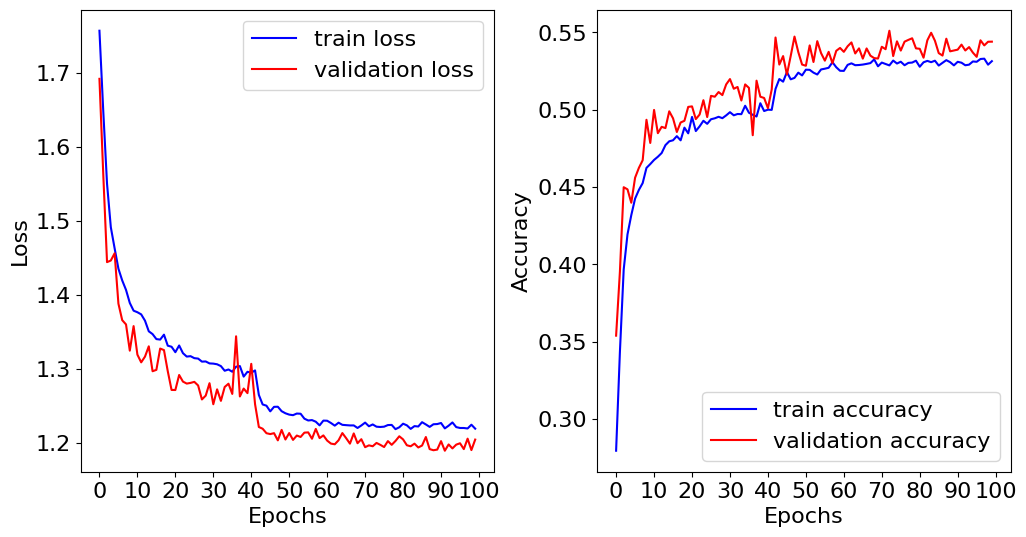

In [102]:
plt.figure(figsize=(12, 6))

# loss plot
plt.subplot(121)
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, EPOCHS + 1, 10))
#plt.xticks(range(EPOCHS), range(1, EPOCHS + 1))
plt.ylabel('Loss')
plt.legend()


# accuracy plot
plt.subplot(122)
plt.plot(train_acc, color='blue', label='train accuracy')
plt.plot(val_acc, color='red', label='validation accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, EPOCHS + 1, 10))
#plt.xticks(range(EPOCHS), range(1, EPOCHS + 1))
plt.ylabel('Accuracy')
plt.legend()
plt.subplots_adjust(wspace=0.25)
plt.show()

# Define Test Function

In [99]:
classes = list(emotion_labels.values())
def test(model, dataloader):
    model.eval()

    # prepare to count predictions for each class
    correct_pred = defaultdict(int)
    total_pred = defaultdict(int)

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing...", total=len(dataloader)):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            all_labels.extend(labels)
            all_predictions.extend(predictions)

            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    return correct_pred, total_pred, all_labels, all_predictions

correct_pred, total_pred, all_labels, all_predictions = test(model, test_dataloader)

Testing...:   0%|          | 0/57 [00:00<?, ?it/s]

<ipython-input-88-d62a1405d376>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


# Test Accuracy for Each Class

In [100]:
for classname, correct_count in dict(sorted(correct_pred.items())).items():
    accuracy = float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.4f}')

total_acc = sum(correct_pred[class_name] for class_name in classes) / len(test_dataset)
print(f"Total test accuracy: {total_acc:.4f}")

Accuracy for class: Angry is 0.3523
Accuracy for class: Disgust is 0.0727
Accuracy for class: Fear  is 0.2121
Accuracy for class: Happy is 0.8271
Accuracy for class: Neutral is 0.5399
Accuracy for class: Sad   is 0.4848
Accuracy for class: Surprise is 0.7163
Total test accuracy: 0.5405


# Confusion Matrix

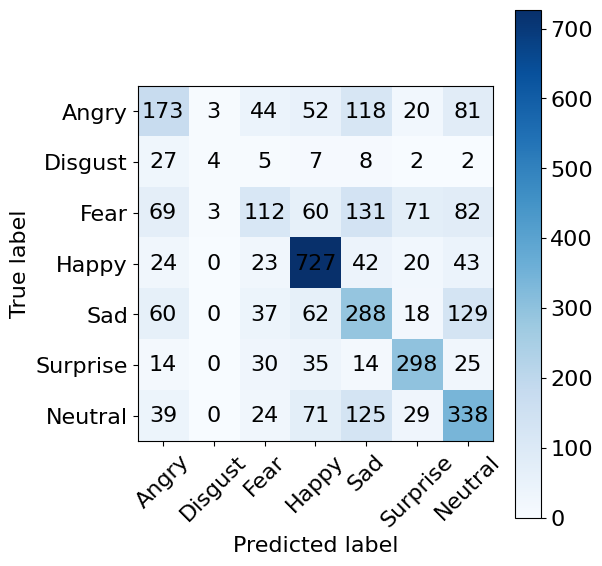

In [101]:
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix)
    for i in range(0, len(classes)):
        for j in range(0, len(classes)):
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ticks = np.arange(len(classes))
    ax.set_xticks(ticks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(all_labels, all_predictions)
plt.show()